**IMPORT THE NECESSARY LIBRARIES**

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

**READING THE DATA FILE**

In [2]:
hotels = pd.read_csv("data/hotel_bookings.csv")
hotels

Booking_ID  no_of_adults  ...  no_of_special_requests  booking_status
0       INN00001           NaN  ...                     NaN    Not_Canceled
1       INN00002           2.0  ...                     1.0    Not_Canceled
2       INN00003           1.0  ...                     0.0        Canceled
3       INN00004           2.0  ...                     0.0        Canceled
4       INN00005           2.0  ...                     0.0        Canceled
...          ...           ...  ...                     ...             ...
36270   INN36271           3.0  ...                     1.0    Not_Canceled
36271   INN36272           2.0  ...                     2.0        Canceled
36272   INN36273           2.0  ...                     2.0    Not_Canceled
36273   INN36274           2.0  ...                     0.0        Canceled
36274   INN36275           2.0  ...                     0.0    Not_Canceled

[36275 rows x 19 columns]

**UNDERSTANDING THE FEATURES IN THE DATASET**

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          35862 non-null  float64
 2   no_of_children                        35951 non-null  float64
 3   no_of_weekend_nights                  35908 non-null  float64
 4   no_of_week_nights                     35468 non-null  float64
 5   type_of_meal_plan                     35749 non-null  object 
 6   required_car_parking_space            33683 non-null  float64
 7   room_type_reserved                    35104 non-null  object 
 8   lead_time                             35803 non-null  float64
 9   arrival_year                          35897 non-null  float64
 10  arrival_month                         35771 non-null  float64
 11  arrival_date   

In [4]:
hotels.describe()

no_of_adults  no_of_children  ...  avg_price_per_room  no_of_special_requests
count  35862.000000    35951.000000  ...        35815.000000            35486.000000
mean       1.845017        0.105366  ...          103.418207                0.619343
std        0.518652        0.402871  ...           35.057342                0.785849
min        0.000000        0.000000  ...            0.000000                0.000000
25%        2.000000        0.000000  ...           80.300000                0.000000
50%        2.000000        0.000000  ...           99.450000                0.000000
75%        2.000000        0.000000  ...          120.000000                1.000000
max        4.000000       10.000000  ...          540.000000                5.000000

[8 rows x 14 columns]

**CHECK FOR MISSING VALUES IN THE DATASET**

In [5]:
hotels.isna().sum()

Booking_ID                                 0
no_of_adults                             413
no_of_children                           324
no_of_weekend_nights                     367
no_of_week_nights                        807
type_of_meal_plan                        526
required_car_parking_space              2592
room_type_reserved                      1171
lead_time                                472
arrival_year                             378
arrival_month                            504
arrival_date                             981
market_segment_type                     1512
repeated_guest                           586
no_of_previous_cancellations             497
no_of_previous_bookings_not_canceled     550
avg_price_per_room                       460
no_of_special_requests                   789
booking_status                             0
dtype: int64

**ALMOST EVERY COLUMN IN THE DATASET HAS CONSIDERABLE NUMBER OF MISSING VALUES. THEREFORE, IT IS IMPORTANT TO DECIDE WHETHER THOSE MISSING VALUES MUST BE REMOVED OR REPLACED BY OTHER VALUES.**

**OF ALL THE COLUMNS, 'Booking_ID', 'arrival_date', 'market_segment_type' APPEAR TO BE LESS EFFECTIVE AND WOULD NOT IMPACT THE BOOKING CANCELLATION TO THE EXTENT OTHER FEATURES DO. HENCE THOSE COLUMNS WERE DROPPED FROM THE DATAFRAME.**

In [6]:
hotels1=hotels.drop(['Booking_ID','arrival_date','market_segment_type'],axis=1)

**THE REVISED DATASET**

In [7]:
hotels1

no_of_adults  no_of_children  ...  no_of_special_requests  booking_status
0               NaN             NaN  ...                     NaN    Not_Canceled
1               2.0             0.0  ...                     1.0    Not_Canceled
2               1.0             0.0  ...                     0.0        Canceled
3               2.0             0.0  ...                     0.0        Canceled
4               2.0             0.0  ...                     0.0        Canceled
...             ...             ...  ...                     ...             ...
36270           3.0             0.0  ...                     1.0    Not_Canceled
36271           2.0             0.0  ...                     2.0        Canceled
36272           2.0             0.0  ...                     2.0    Not_Canceled
36273           2.0             0.0  ...                     0.0        Canceled
36274           2.0             0.0  ...                     0.0    Not_Canceled

[36275 rows x 16 columns]

**THE VALUES FOR TARGET VARIABLE 'booking_status' ARE STRING. BUT WE NEED TO LABEL-ENCODE THE VALUES SO THAT WE CAN FIND THE CORRELATION BETWEEN TARGET AND INPUT FEATURES.**

In [8]:
le=LabelEncoder()
hotels1['booking_status']=le.fit_transform(hotels1['booking_status'])

**NOW THE LABEL VALUES FOR 'booking_status' ARE ENCODED SUCH THAT '1' STANDS FOR 'Not_Canceled' WHILE '0' STANDS FOR 'Canceled'**

In [9]:
hotels1['booking_status']

0        1
1        1
2        0
3        0
4        0
        ..
36270    1
36271    0
36272    1
36273    0
36274    1
Name: booking_status, Length: 36275, dtype: int64

**HEATMAP FOR ANALYZING THE CORRELATION BETWEEN FEATURES**

<AxesSubplot: >

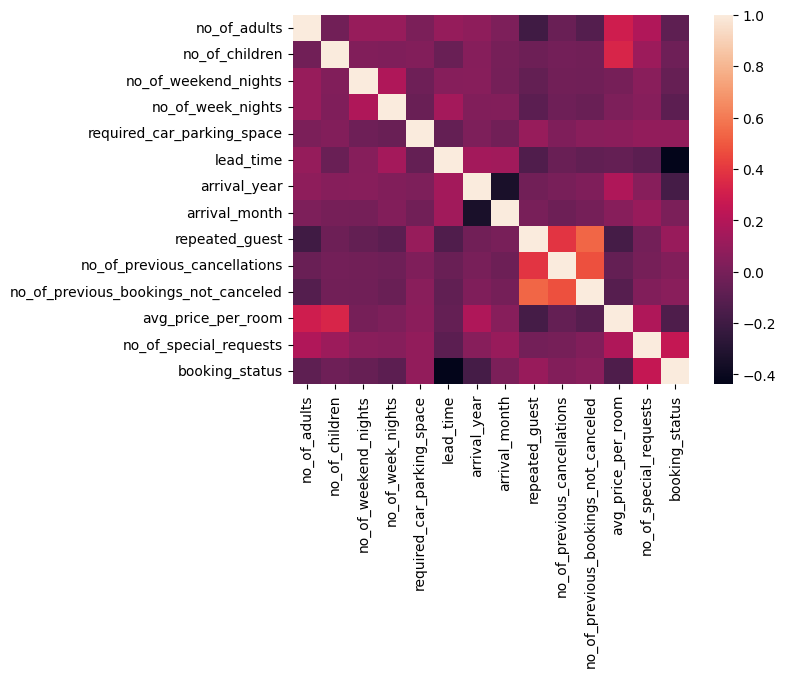

In [10]:
sns.heatmap(hotels1.corr())

**FROM THE ABOVE HEATMAP, IT IS QUITE COMPLICATED TO DRAW ANY KEY CONCLUSION SINCE THERE ISN'T MUCH OF A CORRELATION BETWEEN THE FEATURES. COMPARED TO ALL OTHER INPUT FEATURES, 'no_of_special_requests' DOES HAVE A BETTER RELATION WITH 'booking_status' WHILE 'lead_time' HAS THE LEAST CORRELATION WITH THE TARGET VARIABLE.**

**EXPLORE THE VALUES IN SOME OF THE COLUMNS SO AS TO GET AN IDEA ABOUT HOW TO HANDLE THE MISSING VALUES**

In [11]:
hotels['no_of_previous_bookings_not_canceled'].unique()

array([nan,  0.,  5.,  1.,  3.,  4., 12., 19.,  2., 15., 17.,  7., 20.,
       16., 50., 13.,  6., 14., 34., 18.,  8., 10., 23., 11., 49., 47.,
       53.,  9., 33., 22., 24., 52., 21., 48., 28., 39., 25., 31., 38.,
       26., 51., 42., 37., 35., 56., 44., 27., 32., 55., 45., 30., 57.,
       46., 54., 43., 58., 41., 29., 40., 36.])

In [12]:
hotels1['no_of_children'].unique()

array([nan,  0.,  2.,  1.,  3., 10.,  9.])

In [13]:
hotels1['repeated_guest'].unique()

array([nan,  0.,  1.])

In [14]:
hotels1['no_of_previous_cancellations'].unique()

array([nan,  0.,  3.,  1.,  2., 11.,  4.,  5., 13.,  6.])

In [15]:
hotels1['required_car_parking_space'].unique()

array([nan,  0.,  1.])

In [16]:
hotels1['no_of_special_requests'].unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5.])

**HANDLING THE MISSING VALUES BY REPLACING THEM BY THE MEAN, MEDIAN OR MODE OF THE COLUMN. ALL THOSE COLUMNS WITH MISSING VALUES COULD HAVE BEEN HANDLED IN THE SAME WAY. BUT ONLY SELECTIVE FEATURES WERE CONSIDERED SINCE THIS GAVE MORE ACCURACY WHILE MODELLING.**

In [17]:
hotels1['avg_price_per_room'].fillna(hotels1['avg_price_per_room'].median(), inplace=True)
hotels1['no_of_previous_bookings_not_canceled'].fillna(hotels1['no_of_previous_bookings_not_canceled'].median(), inplace=True)
hotels1['no_of_weekend_nights'].fillna(hotels1['no_of_weekend_nights'].median(), inplace=True)
hotels1['no_of_week_nights'].fillna(hotels1['no_of_week_nights'].median(), inplace=True)
hotels1['no_of_previous_cancellations'].fillna(hotels1['no_of_previous_cancellations'].median(), inplace=True)
hotels1['repeated_guest'].fillna(hotels1['repeated_guest'].mode()[0], inplace=True)
hotels1['required_car_parking_space'].fillna(hotels1['required_car_parking_space'].mode()[0], inplace=True)

**CHECK THE COLUMNS LEFT OUT WITH MISSING VALUES. NOW IT'S BETTER TO REMOVE THE ROWS WITH MISSING VALUES. AS THE RATIO OF DATASET SIZE TO THE SIZE OF ROWS WITH MISSING VALUES IS HUGE, REMOVING THOSE ROWS WON'T CREATE ANY SIGNIFICANT BIAS OR VARIANCE**

In [18]:
hotels1.isnull().sum()

no_of_adults                             413
no_of_children                           324
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        526
required_car_parking_space                 0
room_type_reserved                      1171
lead_time                                472
arrival_year                             378
arrival_month                            504
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                         0
no_of_special_requests                   789
booking_status                             0
dtype: int64

**REMOVING THE ROWS WITH MISSING VALUES**

In [19]:
hotels1=hotels1.dropna()


In [20]:
hotels1

no_of_adults  no_of_children  ...  no_of_special_requests  booking_status
1               2.0             0.0  ...                     1.0               1
2               1.0             0.0  ...                     0.0               0
3               2.0             0.0  ...                     0.0               0
4               2.0             0.0  ...                     0.0               0
5               2.0             0.0  ...                     1.0               0
...             ...             ...  ...                     ...             ...
36269           2.0             2.0  ...                     0.0               0
36271           2.0             0.0  ...                     2.0               0
36272           2.0             0.0  ...                     2.0               1
36273           2.0             0.0  ...                     0.0               0
36274           2.0             0.0  ...                     0.0               1

[32470 rows x 16 columns]

In [21]:
hotels1['room_type_reserved'].value_counts()

Room_Type 1    25187
Room_Type 4     5419
Room_Type 6      866
Room_Type 2      616
Room_Type 5      235
Room_Type 7      142
Room_Type 3        5
Name: room_type_reserved, dtype: int64

In [22]:
hotels1['type_of_meal_plan'].value_counts()

Meal Plan 1     24935
Not Selected     4590
Meal Plan 2      2940
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

In [23]:
hotels1['required_car_parking_space'].value_counts()

0.0    31518
1.0      952
Name: required_car_parking_space, dtype: int64

**ROWS WHERE 'room_type_reserved' VALUE IS 'Room_Type 3' AND 'type_of_meal_plan' VALUE IS 'Meal Plan 3' CAN BE NEGLECTED SINCE THEIR OCCURENCE COUNT IS MINIMAL**

In [24]:
hotels1 = hotels1[hotels1['room_type_reserved']!='Room_Type 3']
hotels1 = hotels1[hotels1['type_of_meal_plan']!='Meal Plan 3']

**FINAL REVISED DATASET**

In [25]:
hotels1

no_of_adults  no_of_children  ...  no_of_special_requests  booking_status
1               2.0             0.0  ...                     1.0               1
2               1.0             0.0  ...                     0.0               0
3               2.0             0.0  ...                     0.0               0
4               2.0             0.0  ...                     0.0               0
5               2.0             0.0  ...                     1.0               0
...             ...             ...  ...                     ...             ...
36269           2.0             2.0  ...                     0.0               0
36271           2.0             0.0  ...                     2.0               0
36272           2.0             0.0  ...                     2.0               1
36273           2.0             0.0  ...                     0.0               0
36274           2.0             0.0  ...                     0.0               1

[32460 rows x 16 columns]

**SPLITTING THE DATASET INTO INPUT FEATURES (X) AND TARGET VARIABLE (Y)**

In [26]:
X=hotels1.drop(columns=['booking_status'])
Y=hotels1['booking_status']

In [27]:
X

no_of_adults  no_of_children  ...  avg_price_per_room  no_of_special_requests
1               2.0             0.0  ...              106.68                     1.0
2               1.0             0.0  ...               60.00                     0.0
3               2.0             0.0  ...              100.00                     0.0
4               2.0             0.0  ...               94.50                     0.0
5               2.0             0.0  ...              115.00                     1.0
...             ...             ...  ...                 ...                     ...
36269           2.0             2.0  ...              216.00                     0.0
36271           2.0             0.0  ...               90.95                     2.0
36272           2.0             0.0  ...               98.39                     2.0
36273           2.0             0.0  ...               94.50                     0.0
36274           2.0             0.0  ...              161.67                     0.0

[32460 rows x 15 columns]

In [28]:
Y

1        1
2        0
3        0
4        0
5        0
        ..
36269    0
36271    0
36272    1
36273    0
36274    1
Name: booking_status, Length: 32460, dtype: int64

**THE RANGE OF VALUES OF THE COLUMNS 'lead_time' AND 'avg_price_per_room' IS TOO HIGH AND HENCE THEY NEED TO SCALED TO A UNIFORM RANGE OF VALUES**

In [29]:
minmax = MinMaxScaler()
X['lead_time'] = minmax.fit_transform(X['lead_time'].values.reshape(-1, 1))
X['avg_price_per_room'] = minmax.fit_transform(X['avg_price_per_room'].values.reshape(-1, 1))


# Are cancellations more likely during weekends?

COUNT OF WEEKEND CANCELLATIONS

In [30]:
len(hotels1[(hotels1['booking_status']=='Canceled') & (hotels1['no_of_weekend_nights']>0)]['no_of_weekend_nights'])

0

COUNT OF WEEKEDAYS CANCELLATION

In [31]:
len(hotels1[(hotels1['booking_status']=='Canceled') & (hotels1['no_of_week_nights']>0)]['no_of_week_nights'])

0

**COMPARE THE COUNT VALUES USING A VISUAL REPRESENTATION**

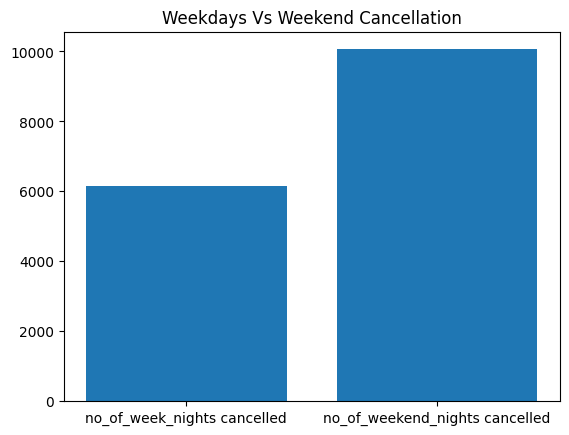

In [32]:
val=[6140,10060]
val1=['no_of_week_nights cancelled','no_of_weekend_nights cancelled']
plt.title('Weekdays Vs Weekend Cancellation')
plt.bar(val1,val)
plt.show()

### **FROM THE ABOVE GRAPH IT IS CLEAR THAT CANCELLATIONS ARE MORE IN THE WEEKENDS THAN IN THE WEEKDAYS**

### SOME IN-DEPTH ANALYSIS AS TO HOW SOME FEATURES ARE RELATED TO BOOKING STATUS

In [33]:
fig = px.histogram(hotels1, x=hotels1["no_of_special_requests"],
             color='booking_status', barmode='group',width=700,title="Special Request Count Vs Booking Status",
             height=500)
fig.show()

In [34]:
fig = px.histogram(hotels1, x=hotels1["required_car_parking_space"],
             color='booking_status', barmode='group',width=700,title="Required Car Parking Space Vs Booking Status",
             height=500)
fig.show()

**MOST OF THE BOOKINGS DID NOT REQUIRE CAR PARKING SPACE**

In [35]:
fig = px.histogram(hotels1, x=hotels1["arrival_year"],
             color='booking_status', barmode='group',width=700,title="Year Vs Booking Status",
             height=500)
fig.show()

### **IN BOTH THE YEARS 2017 AND 2018, COUNT OF BOOKINGS NOT CANCELED ARE MORE THAN THOSE BEING CANCELED. ADDED TO THIS, THE COUNT OF BOOKINGS IN 2018 IS MORE THAN THE COUNT IN 2017. THIS ALSO MEANS THE HOTEL HAS MANAGED TO ATTRACT MORE AUDIENCES WITHIN A YEAR WHICH IS ALSO A SIGN OF POSITIVE PROGRESS.**

In [36]:
fig = px.histogram(hotels1, x=hotels1["type_of_meal_plan"],
             color='booking_status', barmode='group',width=700,title="Meal Plan type Vs Booking Status",
             height=500)
fig.show()

### - FROM THE ABOVE BAR GRAPH, WE CAN SAY THAT MAJORITY OF THE CUSTOMERS HAVE PREFERED 'Meal Plan 1' OVER OTHER MEAL PLAN 2.
### - MOREOVER, COUNT OF CUSTOMERS FOR 'Not Selected' IS MORE THAN 'Meal Plan 2'. 
### - THIS NOT ONLY SHOWS THE LEAST COUNT IN 'Meal Plan 2' BUT ALSO THAT THE DIFFERENCE BETWEEN THE NUMBER OF BOOKINGS CANCELED AND NUMBER OF BOOKINGS NOT CANCELED IS LESS IN 'Meal Plan 2' THAN OTHER CATEGORIES. ALSO THE OVERALL COUNT IN 'Meal Plan 2' IS HIGHLY NEGLIGIBLE.
### - HENCE, THE HOTEL CAN FOCU MORE ON 'Meal Plan 1' WHICH HAS DRAWN MORE AUDIENCES AND CAN EVEN DISREGARD OR REMOVE THE OPTION OF 'Meal Plan 2'.

In [37]:
fig = px.histogram(hotels1, x=hotels1["room_type_reserved"],
             color='booking_status', barmode='group',width=700,title="Room Type Vs Booking Status",
             height=500)
fig.show()

### 'Room_Type 1' HAS WITNESSED THE LRAGEST INTAKE OF PEOPLE WHEREAS THE OTHER ROOM TYPES HAVE A VERY LITTLE COUNT (EXCEPT 'Room Type 4').
### THEREFORE, THE REST OF THE ROOM TYPES HAVE LITERALLY NO SIGNIFICANCE OR FAILED TO IMPRESS THE CUSTOMERS. 
### AS A RESULT IF POSSIBLE, IT IS BETTER TO RENOVATE THE HOTEL SUCH THAT THEY HAVE MORE ROOMS OF ROOM TYPES 1 AND 4.

**RATIO OF BOOKINGS CANCELLED TO THOSE THAT ARE NOT USING A PIE CHART**

<AxesSubplot: ylabel='booking_status'>

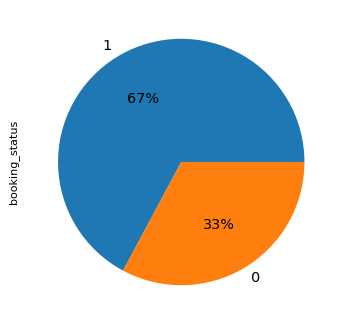

In [38]:
fig = plt.figure(figsize=(5,5), dpi=80)
hotels1['booking_status'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13)

**AS THE COLUMNS 'type_of_meal_plan' AND 'room_type_reserved' ARE CATEGORICAL COLUMNS WITH STRING CATEGORICAL COLUMNS, LABEL ENCODING OF THOSE VALUES IS NECESSARY**

In [39]:
# le = LabelEncoder()
X['type_of_meal_plan']=le.fit_transform(X['type_of_meal_plan'])
X['room_type_reserved']=le.fit_transform(X['room_type_reserved'])

In [40]:
X

no_of_adults  no_of_children  ...  avg_price_per_room  no_of_special_requests
1               2.0             0.0  ...            0.197556                     1.0
2               1.0             0.0  ...            0.111111                     0.0
3               2.0             0.0  ...            0.185185                     0.0
4               2.0             0.0  ...            0.175000                     0.0
5               2.0             0.0  ...            0.212963                     1.0
...             ...             ...  ...                 ...                     ...
36269           2.0             2.0  ...            0.400000                     0.0
36271           2.0             0.0  ...            0.168426                     2.0
36272           2.0             0.0  ...            0.182204                     2.0
36273           2.0             0.0  ...            0.175000                     0.0
36274           2.0             0.0  ...            0.299389                     0.0

[32460 rows x 15 columns]

In [41]:
Y

1        1
2        0
3        0
4        0
5        0
        ..
36269    0
36271    0
36272    1
36273    0
36274    1
Name: booking_status, Length: 32460, dtype: int64

# What factors affect whether customers cancel their booking?

**OF ALL THE ALGORITHMS RELATED TO CLASSIFICATION XGB CLASSIFIER, RANDOM FOREST AND DECISION TREE ARE MORE ROBUST AND WERE GIVING SOME GOOD ACCURACIES. HENCE WE ARE USING THOSE ALGORITHMS FOR MODELLING**

**TEST-TRAIN SPLIT OF X and Y (80% TRAINING DATA AND 20% TESTING DATA)**

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = 111)

**1) XGB CLASSIFIER MODELLING**

In [43]:
xgb_model = XGBClassifier()

In [44]:
xgb_model.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
xgb_pred = xgb_model.predict(xtest)
predictions = [round(value) for value in xgb_pred]

In [46]:
accuracy = (accuracy_score(ytest, predictions))*100.0
print("Accuracy: "+str(accuracy))

Accuracy: 88.20086260012323


**WITHOUT CROSS-VALIDATION, THE ACCURACY WAS APPROXIMATELY 88.2% WHILE WITH CROSS-VALIDATION THE ACCURACY IS 89.2%. THOUGH THIS IS NOT A SIGNIFICANT IMPROVEMENT**

**TOP 7 FACTORS IMPACTING HOTEL CANCELLATIONS (XGB CLASSIFIER)**

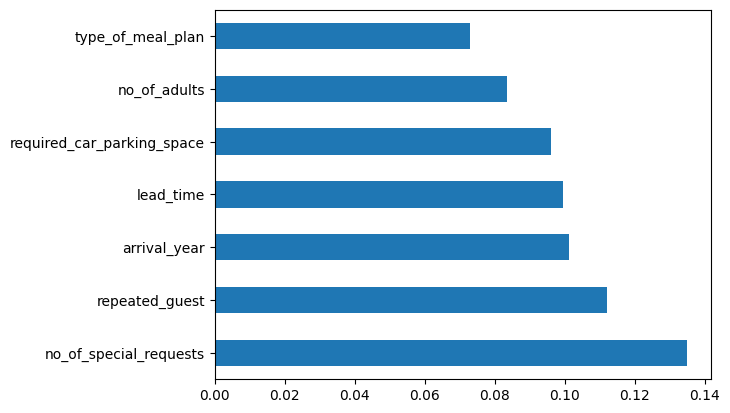

In [47]:
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

**2) RANDOM FOREST CLASSIFIER MODELLING**

In [48]:
forest = RandomForestClassifier(criterion='gini',n_estimators=3,random_state=1,n_jobs=5)
forest.fit(xtrain, ytrain)

RandomForestClassifier(n_estimators=3, n_jobs=5, random_state=1)

In [49]:
forest_pred = forest.predict(xtest)
accuracy1=(accuracy_score(ytest, forest_pred))*100
print(accuracy1)

86.66050523721503


**TOP 7 FACTORS IMPACTING HOTEL CANCELLATIONS (RANDOM FOREST CLASSIFIER)**

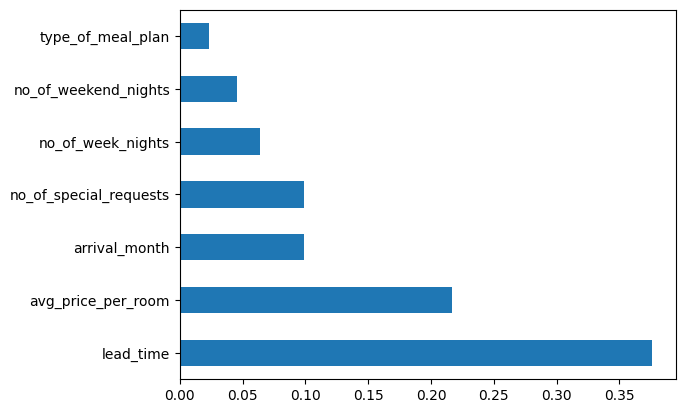

In [50]:
forest_feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
forest_feat_importances.nlargest(7).plot(kind='barh')
plt.show()

**3) DECISION TREE CLASSIFIER MODELLING**

In [51]:
clf = DecisionTreeClassifier()
clf = clf.fit(xtrain,ytrain)

In [52]:
clf_pred = clf.predict(xtest)
accuracy2=(accuracy_score(ytest,clf_pred))*100.0
print(accuracy2)

85.65927295132471


**TOP 7 FACTORS IMPACTING HOTEL CANCELLATIONS (DECISION TREE CLASSIFIER)**

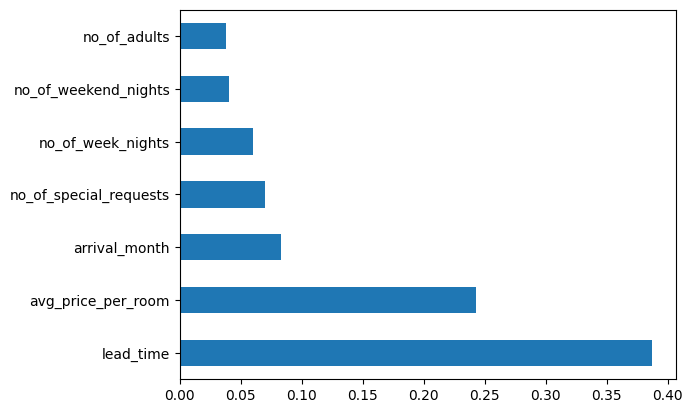

In [53]:
clf_feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
clf_feat_importances.nlargest(7).plot(kind='barh')
plt.show()

**COMPARING THE ACCURACIES OF THE 3 ALGORITHMS**

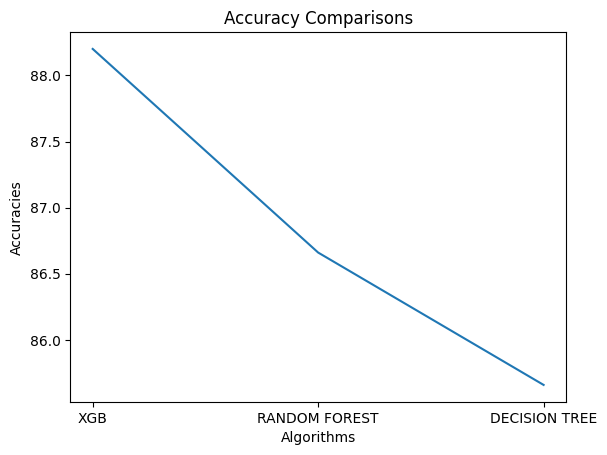

In [54]:
acc = [accuracy, accuracy1,accuracy2]
alg= ['XGB', 'RANDOM FOREST', 'DECISION TREE']
plt.title('Accuracy Comparisons')
plt.xlabel('Algorithms')
plt.ylabel('Accuracies')
plt.plot(alg,acc)
plt.show()

## OF THE 3 POWERFUL ALGORITHMS USED FOR PREDICTING HOTEL CANCELLATION, 'XGB CLASSIFIER' ALGORITHM HAS YIELDED THE HIGHEST ACCURACY. WHILE ANALYZING THE KEY FEATURES CONTRIBUTING TO THE PREDICTION, IT IS CLEAR THAT 'no_of_special_requests' IS AT THE TOP WHICH COINCIDES WHICH WAS THE SAME IN THE CASE OF HEATMAP ANALYSIS. ON THE OTHER SIDES FOR THE OTHER 2 ALGORITHMS, IT APPEARS THAT 'lead_time' IS THE MOST IMPACTING FACTOR THAT EXACTLY CONTRADICTS THE FACT OF HEATMAP WHICH SAYS THAT 'lead_time' IS THE LEAST CORRELATING FACTOR WITH TARGET VARIABLE. 